<a href="https://colab.research.google.com/github/z-tufekci/DeepLearning/blob/main/VariationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use keras and tensorflow to implement VAE ⏭

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

**REPARAMETERIZATION TRICK:** 
This sampling uses mean and logarithmic variance and sample z by using random value from normal distribution. ⚓ Reparameterization sample was first introduced [Kingma and Welling, 2013](https://arxiv.org/pdf/1312.6114.pdf) The process also defined by [Gunderson](https://gregorygundersen.com/blog/2018/04/29/reparameterization/). ♋

In [53]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

 VAE Encoder ▶ ▶ ▶ 

 ☕ Encoder create z_mean and z_variance, then sample z from this z_mean and z_variance using epsilon. 

In [54]:
latent_dim = 2 # because of z_mean and z_log_variance
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
print(conv_shape)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

(None, 7, 7, 64)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 32)   320         ['input_6[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_6[0][0]']               
                                                                                                  
 flatten_2 (Flatten)            (None, 3136)         0           ['conv2d_7[0][0]']               
                                                                           

VAE Decoder ◀ ◀ ◀

☁ The tied architecture (reverse architecture from encoder to decoder) is preferred in AE. There is an [explanation](https://https://stats.stackexchange.com/questions/419684/why-is-the-autoencoder-decoder-usually-the-reverse-architecture-as-the-encoder) about it.

---



In [55]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation="relu")(latent_inputs) # 7x7x64 shape
x = layers.Reshape((conv_shape[1],conv_shape[2], conv_shape[3]))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 28, 28, 1)        289 

VAE MODEL ✅

In [56]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


⛹ If you want to run it on your desktop, you can download [data](https://https://www.kaggle.com/nikbearbrown/tmnist-alphabet-94-characters) and read from same directory with this ipynb file 

In [13]:
import pandas as pd
df = pd.read_csv('gdrive/My Drive/DeepLearning/94_character_TMNIST.csv')
#df = pd.read_csv('94_character_TMNIST.csv')  

In [14]:
print(df.shape)
X = df.drop(columns={'names','labels'})

(274093, 786)


In [15]:
X_images = X.values.reshape(-1,28,28)
X_images = np.expand_dims(X_images, -1).astype("float32") / 255

⚡ I tried different batch size(32,64,128,256) to train VAE model, 128 gives better result than others. 

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_images, epochs=10, batch_size=128)

⛳ This plot latent space plot image between **[scale_x_left , scale_x_right]** and **[scale_y_bottom, scale_y_top]**

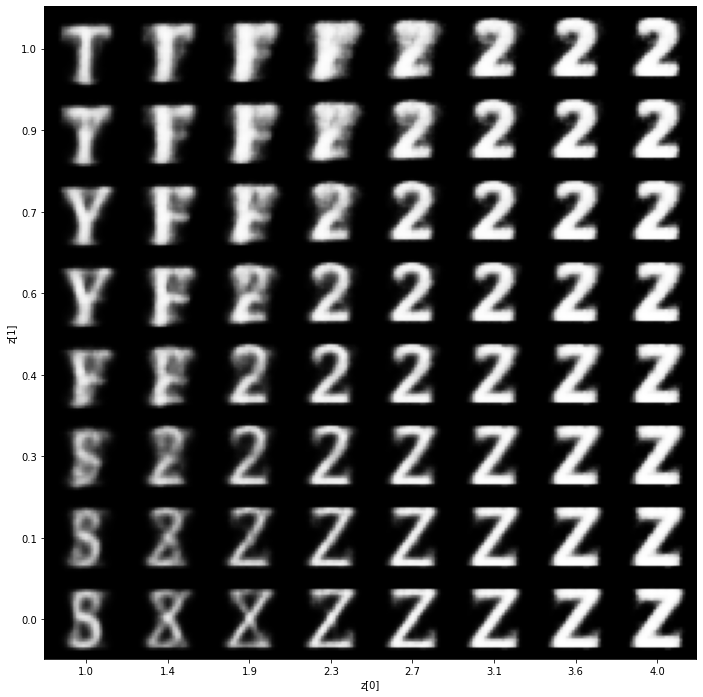

In [50]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=8, figsize=12):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale_x_left = 1 # If we change the range, t generate different image.  
    scale_x_right = 4
    scale_y_bottom = 0
    scale_y_top = 1
    figure = np.zeros((digit_size * n, digit_size * n))
    # If we want to see different x and y range we can change values in grid_x and gird_y. I trid x= [-3,-2] and y = [-3,-1] values and m labeled imaged are generated.
    grid_x = np.linspace(scale_x_left, scale_x_right, n)        # -3, -2
    grid_y = np.linspace(scale_y_bottom, scale_y_top, n)[::-1]  # -3, -1 

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)

♑ When we plot all the Training data with labels, we can see ***z_mean*** values of the data. ❎ If we sample with this ***z_mean*** value, we can acquire similar image from this latent space. ⭕ Because two points are close to each other in latent space means they are looking similar(variant of this label). 

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


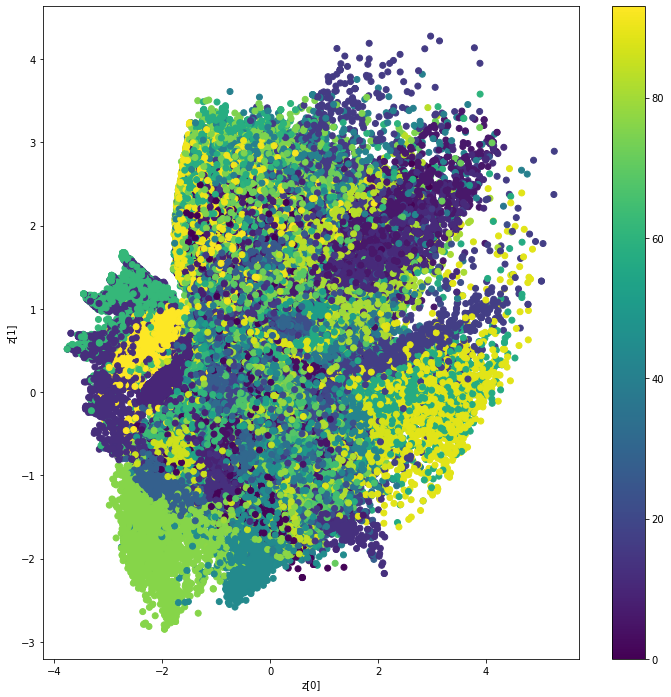

In [37]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 12))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

y = df[['labels']]
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_label = le.fit_transform(y)
plot_label_clusters(vae, X_images, y_label)

 ⛪ Visualize one image

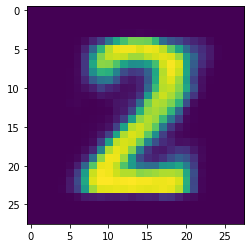

In [48]:

#Single decoded image with random input latent vector (of size 1x2)
#Latent space range is about -5 to 5 so pick random values within this range
sample_vector = np.array([[3,0.5]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28, 28)
plt.imshow(decoded_example_reshaped)

# REFERENCES

1.   [Variational AutoEncoder](https://https://keras.io/examples/generative/vae/)
2.   [Variational autoencoders using keras on MNIST data](https://https://www.youtube.com/watch?v=8wrLjnQ7EWQ) and GitHub [link](https://https://github.com/bnsreenu/python_for_microscopists/blob/master/178_179_variational_autoencoders_mnist.py) 






